In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from helpers import ILottoCSV, beam_search_decoder
from helpers import fetch_dataset, train_test_split
from train import get_compiled_model, train, EPOCHS, BATCH_SIZE, LR_MAX, LR_MIN

print("Tensorflow version " + tf.__version__)
tf.config.optimizer.set_jit(True)

Tensorflow version 2.19.0


In [2]:
orig_lotto_csv="input/Orig_IL_lotto.csv"
lotto_csv_file="input/lotto_IL_filtered.csv"

lotto_ds = fetch_dataset(orig_lotto_csv, lotto_csv_file)
X_train, y_train, X_test, y_test = train_test_split(lotto_ds)

ILottoCSV(orig_lotto_csv, lotto_csv_file)

lotto = pd.read_csv(lotto_csv_file, index_col = 'Date')
print(lotto)

            Ball_1  Ball_2  Ball_3  Ball_4  Ball_5  Ball_6  Ball_Bonus
Date                                                                  
25/03/2025       6      13      18      20      22      28           5
22/03/2025       1       3       8      14      17      33           2
20/03/2025       2       8      11      21      25      34           2
18/03/2025      10      11      23      26      29      34           1
15/03/2025       4       7       9      10      12      27           7
...            ...     ...     ...     ...     ...     ...         ...
29/10/1968       3       9      26      32      34      36           1
15/10/1968       1       6      23      29      33      34           7
08/10/1968       7       9      10      17      23      34           4
01/10/1968       1       7       8       9      11      30           4
03/09/1968       3      14      18      22      25      33           2

[2317 rows x 7 columns]


In [3]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2257, 10, 7)
(2257, 7)
(50, 10, 7)
(50, 7)


In [4]:
model = get_compiled_model()
model.summary()


Model: ""

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_1             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_2             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_3             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_4             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_5             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_6             │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ additive_attention              │ ?                      │   0 (unbuilt) │
│ (AdditiveAttention)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [5]:
history = train(model, X_train, y_train, X_test, y_test, epochs=50, batch_size=BATCH_SIZE)

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.5603 - sparse_top_k: 0.1982
Epoch 1: saving model to training_2/cp-0001.weights.h5
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 3.5587 - sparse_top_k: 0.1988 - val_loss: 3.0517 - val_sparse_top_k: 0.4143
Epoch 2/50
69/71 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.9963 - sparse_top_k: 0.4035
Epoch 2: saving model to training_2/cp-0002.weights.h5
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 2.9943 - sparse_top_k: 0.4041 - val_loss: 2.8899 - val_sparse_top_k: 0.4457
Epoch 3/50
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.8725 - sparse_top_k: 0.4485
Epoch 3: saving model to training_2/cp-0003.weights.h5
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.8721 - sparse_top_k: 0.4484 - val_loss: 2.8633 - val_sparse_top_k: 0.4457
Epoch 4/50
70/71 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 2.8522 - sparse_top_k: 0.4476
Epoch 4: saving model to training_2/cp-0004.weights.h5
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.85

0.47428572177886963


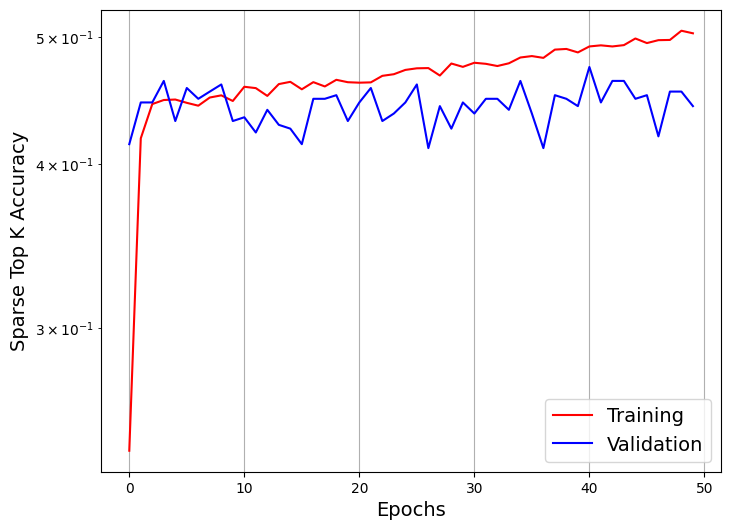

In [6]:
hist = pd.DataFrame(history)
print(hist['val_sparse_top_k'].max())

plt.figure(figsize = (8, 6))
plt.semilogy(hist['sparse_top_k'], '-r', label = 'Training')
plt.semilogy(hist['val_sparse_top_k'], '-b', label = 'Validation')
plt.ylabel('Sparse Top K Accuracy', fontsize = 14)
plt.xlabel('Epochs', fontsize = 14)
plt.legend(fontsize = 14)
plt.grid()
plt.show()

In [7]:
model.load_weights('model/Ilotto.keras')
pred = model.predict(X_test)
pred = np.argmax(pred, axis = 2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step


In [8]:
for i in range(y_test.shape[0]):
    print('Prediction:\t', pred[i] + 1)
    print('GoundTruth:\t', y_test[i] + 1)
    print('-' * 40)

Prediction:	 [ 2 12 18 24 32 37  6]
GoundTruth:	 [ 6 13 18 20 22 28  5]
----------------------------------------
Prediction:	 [ 2 12 21 23 32 37  3]
GoundTruth:	 [ 1  3  8 14 17 33  2]
----------------------------------------
Prediction:	 [ 3 12 19 30 32 37  3]
GoundTruth:	 [ 2  8 11 21 25 34  2]
----------------------------------------
Prediction:	 [ 9 21 27 30 34 37  2]
GoundTruth:	 [10 11 23 26 29 34  1]
----------------------------------------
Prediction:	 [ 1  8 17 24 30 37  4]
GoundTruth:	 [ 4  7  9 10 12 27  7]
----------------------------------------
Prediction:	 [ 1  8 17 27 32 37  4]
GoundTruth:	 [ 3  5 14 19 22 27  2]
----------------------------------------
Prediction:	 [ 1  8 19 30 32 37  4]
GoundTruth:	 [ 1  4 16 26 27 34  2]
----------------------------------------
Prediction:	 [ 1  8 17 24 32 37  4]
GoundTruth:	 [11 15 21 22 28 29  1]
----------------------------------------
Prediction:	 [ 1  8 21 30 33 36  1]
GoundTruth:	 [15 17 21 30 34 37  7]
------------------------

In [9]:
X_latest = X_test[0][1:]
X_latest = np.concatenate([X_latest, y_test[0].reshape(1, 7)], axis = 0)
X_latest = X_latest.reshape(1, X_latest.shape[0], X_latest.shape[1])
print(X_latest + 1)

[[[ 1  7 18 23 26 31  4]
  [ 4  8 15 24 29 30  7]
  [11 16 28 29 31 35  3]
  [ 5  7 19 26 32 33  6]
  [ 8 18 25 29 32 35  2]
  [ 5 13 30 33 34 36  3]
  [ 5  6 26 27 30 32  2]
  [17 22 27 33 34 35  2]
  [ 7 12 15 22 28 33  6]
  [ 6 13 18 20 22 28  5]]]


In [10]:
pred_latest = model.predict(X_latest)
pred_latest = np.squeeze(pred_latest)
pred_latest_greedy = np.argmax(pred_latest, axis = 1)
print(pred_latest_greedy + 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[ 2  8 21 24 29 37  7]


In [11]:
beam_width = 10
replace = True

result = beam_search_decoder(pred_latest, beam_width, replace)
print('Beam Width:\t', beam_width)
print('Replace:\t', replace)
print('-' * 85)
for seq in result:
    print('Prediction: ', np.array(seq[0]) + 1, '\tLog Likelihood: ', seq[1])

2025-03-29 18:25:26,752 - helpers - INFO - Beam search decoder


Beam Width:	 10
Replace:	 True
-------------------------------------------------------------------------------------
Prediction:  [ 2  8 21 24 29 37  7] 	Log Likelihood:  -15.898898370918223
Prediction:  [ 2  8 21 24 26 37  7] 	Log Likelihood:  -15.92944404841316
Prediction:  [ 2  8 21 24 32 37  7] 	Log Likelihood:  -15.955014718757392
Prediction:  [ 2  8 18 24 29 37  7] 	Log Likelihood:  -15.95828463696232
Prediction:  [ 2  8 21 24 29 34  7] 	Log Likelihood:  -15.960441394076163
Prediction:  [ 8  8 21 24 29 37  7] 	Log Likelihood:  -15.979327416672119
Prediction:  [ 2  8 17 24 29 37  7] 	Log Likelihood:  -15.982577982510827
Prediction:  [ 2  8 18 24 26 37  7] 	Log Likelihood:  -15.988830314457257
Prediction:  [ 2  8 21 26 29 37  7] 	Log Likelihood:  -15.989697758282366
Prediction:  [ 2  8 21 24 26 34  7] 	Log Likelihood:  -15.9909870715711


In [12]:
beam_width = 10
replace = False

result = beam_search_decoder(pred_latest, beam_width, replace)
print('Beam Width:\t', beam_width)
print('Replace:\t', replace)
print('-' * 85)
for seq in result:
    print('Prediction: ', np.array(seq[0]) + 1, '\tLog Likelihood: ', seq[1])

2025-03-29 18:25:26,757 - helpers - INFO - Beam search decoder


Beam Width:	 10
Replace:	 False
-------------------------------------------------------------------------------------
Prediction:  [ 2  8 21 24 29 37  7] 	Log Likelihood:  -15.898898370918223
Prediction:  [ 2  8 21 24 26 37  7] 	Log Likelihood:  -15.92944404841316
Prediction:  [ 2  8 21 24 32 37  7] 	Log Likelihood:  -15.955014718757392
Prediction:  [ 2  8 18 24 29 37  7] 	Log Likelihood:  -15.95828463696232
Prediction:  [ 2  8 21 24 29 34  7] 	Log Likelihood:  -15.960441394076163
Prediction:  [ 2  8 17 24 29 37  7] 	Log Likelihood:  -15.982577982510827
Prediction:  [ 2  8 18 24 26 37  7] 	Log Likelihood:  -15.988830314457257
Prediction:  [ 2  8 21 26 29 37  7] 	Log Likelihood:  -15.989697758282366
Prediction:  [ 2  8 21 24 26 34  7] 	Log Likelihood:  -15.9909870715711
Prediction:  [ 2  8 21 24 28 37  7] 	Log Likelihood:  -15.99501709984224
